In [11]:
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from langchain_groq import ChatGroq  # Assuming you are using the langchain_groq package
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

# Load datasets
X_train = np.load('FinalDataset/X_train.npy')
X_test = np.load('FinalDataset/X_test.npy')
y_train = np.load('FinalDataset/y_train.npy')
y_test = np.load('FinalDataset/y_test.npy')

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
X_train shape:  (126, 500, 3)
X_test shape:  (54, 500, 3)
y_train shape:  (126,)
y_test shape:  (54,)


In [12]:
# Feature extraction and processing steps...
import tsfel

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_features = tsfel.time_series_features_extractor(cfg, X_train, verbose=1, fs=50)
X_test_features = tsfel.time_series_features_extractor(cfg, X_test, verbose=1, fs=50)

# Remove highly correlated features
correlated_features = tsfel.correlated_features(X_train_features)
X_train_filtered = X_train_features.drop(correlated_features, axis=1)
X_test_filtered = X_test_features.drop(correlated_features, axis=1)

# Remove low variance features
variance_selector = VarianceThreshold(threshold=0)
X_train_reduced = variance_selector.fit_transform(X_train_filtered)
X_test_reduced = variance_selector.transform(X_test_filtered)

# Normalize features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

# Apply PCA
# pca = PCA(n_components=27)
# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)

# print("X_train_pca shape: ", X_train_pca.shape)
# print("X_test_pca shape: ", X_test_pca.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [13]:
filtered_feature_names = X_train_filtered.columns
print("Filtered Feature Names: ", filtered_feature_names)

Filtered Feature Names:  Index(['0_Absolute energy', '0_Autocorrelation', '0_Centroid',
       '0_ECDF Percentile Count_0', '0_ECDF Percentile Count_1',
       '0_ECDF Percentile_0', '0_ECDF_0', '0_ECDF_1', '0_ECDF_2', '0_ECDF_3',
       ...
       '2_Slope', '2_Spectral decrease', '2_Spectral distance',
       '2_Spectral entropy', '2_Spectral positive turning points',
       '2_Spectral roll-on', '2_Spectral variation', '2_Wavelet entropy',
       '2_Wavelet variance_2', '2_Zero crossing rate'],
      dtype='object', length=844)


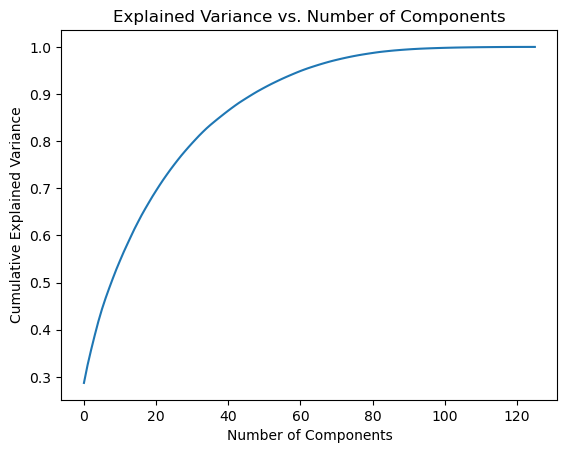

In [5]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_normalized)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


In [24]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd


# Fit a Decision Tree classifier to get feature importances
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_normalized, y_train)

# Get feature importances
importances = clf.feature_importances_

# Number of top features you want
N = 30

# Get indices of the top N features
top_indices = np.argsort(importances)[-N:]

# Get feature names corresponding to the top N features
top_feature_names = [filtered_feature_names[i] for i in top_indices]

# Select the top N important features from the datasets
X_train_important = X_train_normalized[:, top_indices]
X_test_important = X_test_normalized[:, top_indices]

# Display the shapes and feature names
print("X_train_important shape: ", X_train_important.shape)
print("X_test_important shape: ", X_test_important.shape)
print("Top feature names: ", top_feature_names)


# Display the dataframes with the top features
df_train_important = pd.DataFrame(X_train_important, columns=top_feature_names)
df_test_important = pd.DataFrame(X_test_important, columns=top_feature_names)



display(df_train_important)
display(df_test_important)

X_train_important shape:  (126, 30)
X_test_important shape:  (54, 30)
Top feature names:  ['0_Spectral entropy', '0_Mean diff', '0_MFCC_3', '0_MFCC_4', '0_MFCC_5', '0_MFCC_6', '0_MFCC_7', '0_MFCC_8', '0_MFCC_9', '0_Max', '0_Max power spectrum', '0_Maximum frequency', '0_Spectral decrease', '0_Median diff', '2_Histogram_8', '0_Median frequency', '0_Negative turning points', '0_Neighbourhood peaks', '0_Power bandwidth', '0_Skewness', '0_Slope', '0_FFT mean coefficient_41', '0_FFT mean coefficient_99', '2_FFT mean coefficient_56', '1_FFT mean coefficient_205', '0_Min', '1_MFCC_11', '0_FFT mean coefficient_95', '0_FFT mean coefficient_204', '0_ECDF Percentile Count_0']


,0_Spectral entropy,0_Mean diff,0_MFCC_3,0_MFCC_4,0_MFCC_5,0_MFCC_6,0_MFCC_7,0_MFCC_8,0_MFCC_9,0_Max,...,0_Slope,0_FFT mean coefficient_41,0_FFT mean coefficient_99,2_FFT mean coefficient_56,1_FFT mean coefficient_205,0_Min,1_MFCC_11,0_FFT mean coefficient_95,0_FFT mean coefficient_204,0_ECDF Percentile Count_0
0,-0.119186,-0.210685,-0.579478,0.283210,0.368272,0.635078,-0.455216,-0.274490,0.499873,0.062609,...,0.183098,0.026690,0.593082,-0.335589,-0.313311,-0.923887,0.215305,0.280750,-0.261061,0.096451
1,-0.518751,1.239780,-1.208640,0.031040,0.044704,0.208605,-1.129151,-0.110577,-0.567138,-1.675011,...,-0.445277,-0.377601,-0.947584,-0.417592,-0.419523,1.681164,-1.603851,-0.779701,-0.316160,-1.450259
2,-0.521494,-0.530543,0.741762,0.099057,0.152137,-1.736365,0.542396,1.692472,0.385399,0.416528,...,-0.446418,-0.377597,-0.951537,-0.421716,-0.419461,-0.367482,-0.851751,-0.782274,-0.316136,0.849698
3,-0.242487,-0.160529,-0.516562,1.233894,0.531714,0.633870,-1.050232,-1.094057,0.740291,-0.048621,...,-0.173840,0.028891,1.471355,-0.231071,-0.275224,-0.869424,0.303519,0.344734,-0.271390,0.175023
4,-0.116779,-0.414986,-1.145724,0.408881,0.188410,0.628514,-1.241446,0.053337,0.501960,-0.255987,...,0.020219,-0.081527,0.721194,-0.281822,0.624070,-0.654227,-0.074656,0.627844,-0.009031,0.200301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.499686,-0.416927,-0.736768,-0.420929,-0.435637,0.611789,-1.629182,0.217250,0.927398,0.700071,...,-0.243995,-0.164273,0.611502,-0.367548,-0.414663,-0.641589,0.841297,-0.061989,-0.283842,0.245477
122,-0.521516,-0.037695,-1.649053,1.058387,-3.987398,0.500261,-1.816319,-1.749711,-2.931518,0.065039,...,-0.445154,-0.376624,-0.991329,-0.419874,-0.410822,0.522228,-0.614035,-0.754248,-0.313979,0.218701
123,-0.521697,0.639929,0.584471,-0.445999,0.215543,0.278389,-0.406323,-0.110577,-2.108930,-1.851982,...,-0.446969,-0.377558,-1.032455,-0.421580,-0.419620,1.368537,-1.698556,-0.781146,-0.316162,-1.658260
124,0.185515,0.120934,0.427181,0.863506,-0.857061,0.640041,-0.133766,-0.274490,0.286967,-0.346411,...,0.056275,-0.355530,0.871408,0.021351,0.436672,-1.185938,-0.322745,0.349892,-0.313901,0.079749


,0_Spectral entropy,0_Mean diff,0_MFCC_3,0_MFCC_4,0_MFCC_5,0_MFCC_6,0_MFCC_7,0_MFCC_8,0_MFCC_9,0_Max,...,0_Slope,0_FFT mean coefficient_41,0_FFT mean coefficient_99,2_FFT mean coefficient_56,1_FFT mean coefficient_205,0_Min,1_MFCC_11,0_FFT mean coefficient_95,0_FFT mean coefficient_204,0_ECDF Percentile Count_0
0,-0.438225,-0.349915,-0.736768,0.821691,-0.825150,0.646766,-0.691814,0.708991,0.305996,0.449965,...,-0.289098,-0.079678,0.431007,0.190313,4.808412,-0.716924,0.874209,1.276809,0.413246,0.111214
1,-0.327516,-0.286542,-0.673852,-0.117444,0.118745,0.628020,-1.203902,-0.930144,0.665762,1.572930,...,0.080160,-0.343656,-0.154839,0.229558,-0.366802,-0.841201,1.227735,0.116074,-0.311291,0.220641
2,-0.445878,0.358828,-0.956975,0.613322,-0.680455,0.651113,-0.011221,-0.110577,0.088181,0.856822,...,-0.439630,-0.293269,0.699826,-0.338596,-0.362164,-1.451714,-0.398786,0.645658,-0.150772,-0.190568
3,-0.468719,-0.668289,1.433840,-0.276116,-0.118498,-0.410395,0.661245,0.217250,-0.934987,0.498156,...,-0.436112,-0.376637,-0.960311,-0.422024,-0.399911,-0.066238,0.716442,-0.782123,-0.316134,0.918342
4,-0.520369,-0.472636,1.213633,-0.601647,0.144687,-1.894259,1.060186,1.364645,0.810984,0.509066,...,-0.442205,-0.377075,-0.956120,-0.420995,-0.419538,-0.445348,-0.777930,-0.782280,-0.316125,0.938693
5,2.822289,-0.509253,-0.642394,-0.164177,-0.045758,0.636303,-0.854815,-0.766230,0.546091,0.992595,...,0.353489,3.945113,-0.009767,0.154056,-0.322650,-0.454454,0.420472,0.403481,-0.206312,0.112655
6,-0.497310,-0.400654,-0.579478,-0.028226,0.009395,0.622415,-0.452512,-1.585798,0.628751,0.809595,...,-0.265424,0.568774,0.697137,-0.108270,0.332104,-0.742754,0.522770,-0.245254,1.982055,0.351388
7,-0.518709,-0.653675,1.402382,2.774605,0.120644,-1.664077,1.660748,-0.110577,0.525212,0.550537,...,-0.446499,-0.377631,-0.947068,-0.415700,-0.417714,-0.114917,0.010382,-0.782296,-0.316132,0.996954
8,0.354414,-0.214440,-0.894059,0.505761,-0.982473,0.659668,-0.290325,0.708991,-0.330204,0.792985,...,0.781489,-0.142067,1.299953,1.655854,0.977106,-0.915073,0.957663,3.480592,0.839654,-0.333248
9,-0.462854,-0.197385,-0.799685,0.521160,-0.544970,0.621166,-1.464223,-0.766230,0.471509,-0.652421,...,-0.338561,0.341374,1.569111,0.022662,-0.112113,-0.951475,-0.903476,0.184108,-0.181325,0.103793


In [21]:
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}


In [ ]:
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3-70b"  # Use the Llama 3.1-70B model
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Get feature names from the filtered data
feature_names = df_train_important.columns

# Step 2: Prepare your few-shot learning prompt
few_shot_examples = [
    {"input": df_train_important.iloc[i].tolist(), "label": y_train[i]} for i in range(30)  # Example with 30 few-shot samples
]

def create_few_shot_prompt(examples, query_input, feature_names):
    # Description of the data and task
    description = (f'''
        You are a highly trained human activity classification model.
        Each input is a vector containing the following features: {", ".join(feature_names)}.
        The features have been preprocessed and reduced to the most important ones. 
        Your task is to analyze the given input vector and classify the human activity into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING
        Here are a few examples:\n'''
    )

    # Build the prompt with examples and the new query
    prompt = description
    for ex in examples:
        example_input = " | ".join([f"{name}: {value}" for name, value in zip(feature_names, ex['input'])])
        prompt += f"Input: {example_input}\nLabel: {ex['label']}\n\n"
    query_input_str = " | ".join([f"{name}: {value}" for name, value in zip(feature_names, query_input)])
    prompt += "Now, classify the following input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.\n"
    prompt += f"Input: {query_input_str}\nLabel: "
    print(prompt,"\n\n\n")
    return prompt

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break
print("selected_indices: ", selected_indices, [y_test[i] for i in selected_indices])

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = df_test_important.iloc[idx].tolist()
    prompt = create_few_shot_prompt(few_shot_examples, query_input, feature_names)
    
    # Step 5: Make the API call using ChatGroq
    answer = llm.invoke(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    true_label = y_test[idx]
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 2
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 3
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 1
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1


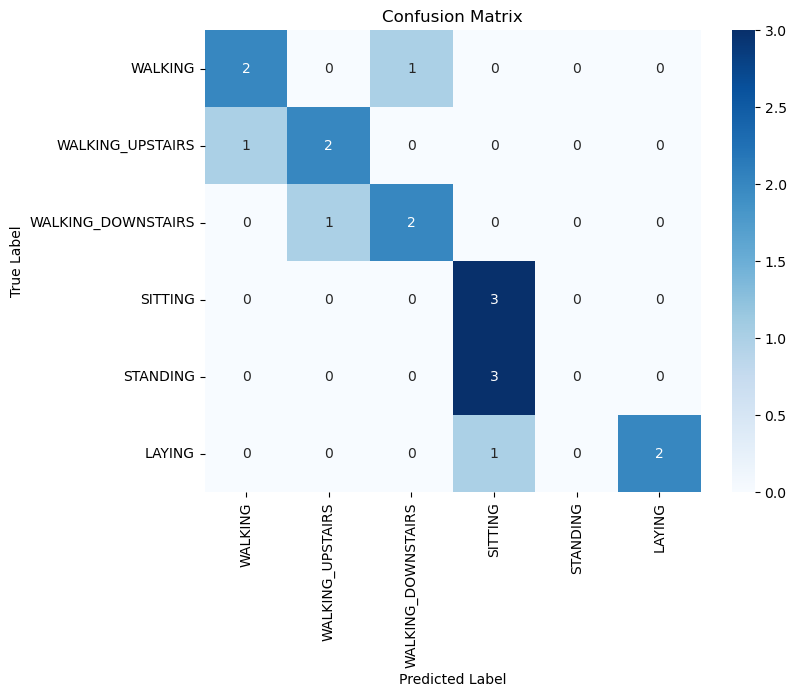

Total tokens used: 202379


In [10]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize token count
token_count = 0

def make_api_call(prompt):
    global token_count
    while True:
        try:
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Step 1: Set up your Groq API credentials and model
Groq_Token = "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"
model_name =  "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Get feature names from the filtered data
feature_names = df_train_important.columns

# Step 2: Prepare your few-shot learning prompt
few_shot_examples = [
    {"input": df_train_important.iloc[i].tolist(), "label": y_train[i]} for i in range(30)  # Example with 30 few-shot samples
]

def create_few_shot_prompt(examples, query_input, feature_names):
    # Description of the data and task
    description = (f'''
        You are a highly trained human activity classification model.
        Each input is a vector containing the following features: {", ".join(feature_names)}.
        The features have been preprocessed and reduced to the most important ones. 
        Your task is to analyze the given input vector and classify the human activity into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING
        Here are a few examples:\n'''
    )

    # Build the prompt with examples and the new query
    prompt = description
    for ex in examples:
        example_input = " | ".join([f"{name}: {value}" for name, value in zip(feature_names, ex['input'])])
        prompt += f"Input: {example_input}\nLabel: {ex['label']}\n\n"
    query_input_str = " | ".join([f"{name}: {value}" for name, value in zip(feature_names, query_input)])
    prompt += "Now, classify the following input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.\n"
    prompt += f"Input: {query_input_str}\nLabel: "
    return prompt

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = df_test_important.iloc[idx].tolist()
    prompt = create_few_shot_prompt(few_shot_examples, query_input, feature_names)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    true_label = y_test[idx]
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print token usage
print(f"Total tokens used: {token_count}")


In [22]:

# Step 1: Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3-70b"  # Use the Llama 3.1-70B model
# llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
import json 

def np_to_string(data):
    '''
    data is a numpy array  
    json.dumps() takes a python object and converts it into a JSON formatted string.
    (JavaScript Object Notation) is a lightweight data-interchange format that is easy for humans to read and write.
    '''
    return json.dumps(data.tolist())

def generate_prompt_with_features(data_str, retained_features):
    """Generate a prompt for the model given the JSON formatted data and retained features."""

    features_str = ', '.join(retained_features)

    return f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    The initial data consisted of:
    - 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

    Data Format:
    - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
    - Static activities tend to have very little variation in the accelerometer data, while dynamic activities tend to have more variation.
    - x axis is the vertical axis, z axis is forward direction and y axis is the side direction.
    - Sitting involves going from standing to sitting posiion.
    - Acceleration is measured in terms of g-force. At rest, the acceleration is 1 (representing gravity).

    This data was processed using feature selection techniques to retain only the most relevant features.

    Here is the accelerometer data provided to you:
    - You have 10 readings, each with 20 selected features after applying feature selection techniques.
    - The features retained include : {features_str}

    Please analyze the data and provide the most likely activity label from the list above. 
    **Provide ONLY the classification label (from the given options above) as output.**

    Data: {data_str}
    """

def classify_activity(llm, prompt):
    """Invoke the model with the prompt and return the classification result."""
    answer = llm.invoke(prompt)
    # print("Meta data:",answer.usage_metadata,"\n")
    return answer.content.strip()

def calculate_accuracy(predictions, true_labels):
    """Calculate and return the accuracy of the predictions."""
    correct = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct / len(predictions)
    return accuracy

import random
import numpy as np

def shuffle_and_sample_data(X, y, samples_per_class):
    """
    Shuffle the data and select a specified number of samples from each class.

    Parameters:
    - X: np.ndarray or list of data samples.
    - y: np.ndarray or list of labels corresponding to the data samples.
    - samples_per_class: Number of samples to select from each class.

    Returns:
    - X_sampled: np.ndarray of sampled data.
    - y_sampled: np.ndarray of sampled labels.
    """
    # Group data by class labels using a regular dictionary
    class_data = {}
    for xi, yi in zip(X, y):
        if yi not in class_data:
            class_data[yi] = []
        class_data[yi].append(xi)
    
    X_sampled = []
    y_sampled = []
    
    # Shuffle and sample from each class
    for class_label, data_samples in class_data.items():
        random.shuffle(data_samples)
        sampled_data = data_samples[:samples_per_class]
        
        X_sampled.extend(sampled_data)
        y_sampled.extend([class_label] * len(sampled_data))
    
    # Convert to np.ndarray if the input was an array
    X_sampled = np.array(X_sampled)
    y_sampled = np.array(y_sampled)
    

    return X_sampled, y_sampled

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def zeroshot(X_train, y_train, llm, samples_per_class=5, feature_columns=None):

    """Main function to classify activities and calculate accuracy."""
    predictions = []

    # Shuffle and sample data
    X_sampled, y_sampled = shuffle_and_sample_data(X_train, y_train, samples_per_class)
    
    # Check if we have enough samples
    num_samples = len(X_sampled)
    print(f"Number of samples in X_sampled: {num_samples}")

    # Ensure the loop does not exceed the number of available samples
    for i in range(min(samples_per_class*6, num_samples)):

        X_i = X_sampled[i]

        # Format the data and generate the prompt
        data_str = np_to_string(X_i)
        prompt = generate_prompt_with_features(data_str, feature_columns)

        # Classify the activity and store the result
        activity_name = classify_activity(llm, prompt)
        activity_number = reverse_activity_labels.get(activity_name, -1)  # Use -1 for unknown activities
        predictions.append(activity_number)

        # Print the predicted activity and true label
        true_activity_name = activity_labels[y_sampled[i]]
        print(f"Predicted Activity: {activity_name}, True Label: {true_activity_name}")

    # Calculate and print accuracy
    accuracy = calculate_accuracy(predictions, y_sampled)
    print(f"Accuracy: {accuracy:.2f}")
    print("Accuracy Percentage: ", accuracy * 100)

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(y_sampled, predictions)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Optionally, visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_labels.values(), yticklabels=activity_labels.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [23]:
## Load the model
import json 


accuracies = []
model_name = "llama3.1-8b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

zeroshot(df_train_important, y_train, llm, samples_per_class=2,feature_columns=filtered_feature_names)
print("\n\n")

Number of samples in X_sampled: 12
Predicted Activity: LAYING, True Label: WALKING_UPSTAIRS
Predicted Activity: LAYING, True Label: WALKING_UPSTAIRS
Predicted Activity: LAYING, True Label: LAYING
Predicted Activity: LAYING, True Label: LAYING
Predicted Activity: LAYING, True Label: STANDING
Predicted Activity: LAYING, True Label: STANDING
Predicted Activity: LAYING, True Label: WALKING
Predicted Activity: LAYING, True Label: WALKING
Predicted Activity: LAYING, True Label: SITTING


KeyboardInterrupt: 

X_train_important shape:  (126, 6)
X_test_important shape:  (54, 6)
Top feature names:  ['1_FFT mean coefficient_205', '0_Min', '1_MFCC_11', '0_FFT mean coefficient_95', '0_FFT mean coefficient_204', '0_ECDF Percentile Count_0']


,1_FFT mean coefficient_205,0_Min,1_MFCC_11,0_FFT mean coefficient_95,0_FFT mean coefficient_204,0_ECDF Percentile Count_0
0,-0.313311,-0.923887,0.215305,0.280750,-0.261061,0.096451
1,-0.419523,1.681164,-1.603851,-0.779701,-0.316160,-1.450259
2,-0.419461,-0.367482,-0.851751,-0.782274,-0.316136,0.849698
3,-0.275224,-0.869424,0.303519,0.344734,-0.271390,0.175023
4,0.624070,-0.654227,-0.074656,0.627844,-0.009031,0.200301
...,...,...,...,...,...,...
121,-0.414663,-0.641589,0.841297,-0.061989,-0.283842,0.245477
122,-0.410822,0.522228,-0.614035,-0.754248,-0.313979,0.218701
123,-0.419620,1.368537,-1.698556,-0.781146,-0.316162,-1.658260
124,0.436672,-1.185938,-0.322745,0.349892,-0.313901,0.079749


,y_FFT mean coefficient_205,x_Min,y_MFCC_yy,x_FFT mean coefficient_95,x_FFT mean coefficient_2x4,x_ECDF Percentile Count_x
0,4.808412,-0.716924,0.874209,1.276809,0.413246,0.111214
1,-0.366802,-0.841201,1.227735,0.116074,-0.311291,0.220641
2,-0.362164,-1.451714,-0.398786,0.645658,-0.150772,-0.190568
3,-0.399911,-0.066238,0.716442,-0.782123,-0.316134,0.918342
4,-0.419538,-0.445348,-0.777930,-0.782280,-0.316125,0.938693
5,-0.322650,-0.454454,0.420472,0.403481,-0.206312,0.112655
6,0.332104,-0.742754,0.522770,-0.245254,1.982055,0.351388
7,-0.417714,-0.114917,0.010382,-0.782296,-0.316132,0.996954
8,0.977106,-0.915073,0.957663,3.480592,0.839654,-0.333248
9,-0.112113,-0.951475,-0.903476,0.184108,-0.181325,0.103793


Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 4
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 4
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 4
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 6
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label for the query input: 6
True label for the query input: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label for the query input: 6
True label for the query input: 1


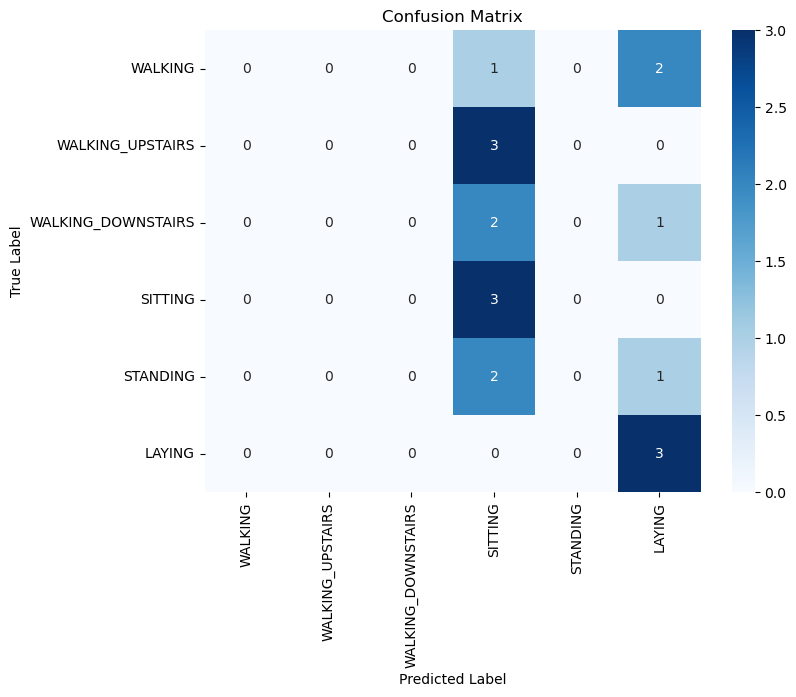

Total tokens used: 8345


In [37]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
import pandas as pd


# Fit a Decision Tree classifier to get feature importances
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_normalized, y_train)

# Get feature importances
importances = clf.feature_importances_

# Number of top features you want
N = 6

# Get indices of the top N features
top_indices = np.argsort(importances)[-N:]

# Get feature names corresponding to the top N features
top_feature_names = [filtered_feature_names[i] for i in top_indices]

# Select the top N important features from the datasets
X_train_important = X_train_normalized[:, top_indices]
X_test_important = X_test_normalized[:, top_indices]



# Display the shapes and feature names
print("X_train_important shape: ", X_train_important.shape)
print("X_test_important shape: ", X_test_important.shape)
print("Top feature names: ", top_feature_names)


# Display the dataframes with the top features
df_train_important = pd.DataFrame(X_train_important, columns=top_feature_names)
df_test_important = pd.DataFrame(X_test_important, columns=top_feature_names)

prefix_map = {
    '0': 'x',
    '1': 'y',
    '2': 'z',
    '3': 'linear_acceleration'
}

# Create a new column name mapping
new_columns = {}
for col in df_test_important.columns:
    prefix = col.split('_')[0]
    if prefix in prefix_map:
        new_prefix = prefix_map[prefix]
        new_col_name = col.replace(prefix, new_prefix)
        new_columns[col] = new_col_name

# Rename the columns
df_test_important.rename(columns=new_columns, inplace=True)
top_feature_names = list(df_test_important.columns)

display(df_train_important)
display(df_test_important)


# Initialize token count
token_count = 0

def make_api_call(prompt):
    global token_count
    while True:
        try:
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Function to generate a zero-shot prompt
# Function to generate a zero-shot prompt
def create_zero_shot_prompt(query_input, retained_features):
    """Generate a prompt for the model given the JSON formatted data and retained features."""
    # Combine features and their corresponding values in "column:value" format
    features_str = ', '.join([f"{feature}:{value}" for feature, value in zip(retained_features, query_input)])

    description = (f"""
    You are a highly trained human activity classification model.
    Each input is a vector containing numerical values that represent specific features of human activity data.
    The data is presented as pairs of column names and their corresponding values.

    The data consists of {N} features extracted from the Human Activity Recognition dataset. 
    Your task is to analyze the given input vector and classify the human activity into one of the following categories:
    - 1: WALKING
    - 2: WALKING_UPSTAIRS
    - 3: WALKING_DOWNSTAIRS
    - 4: SITTING 
    - 5: STANDING
    - 6: LAYING

    The initial data consisted of:
    - 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

    Data Format:
    - Static activities tend to have very little variation in the accelerometer data, while dynamic activities tend to have more variation.
    - x axis is the vertical axis, z axis is forward direction, and y axis is the side direction.
    - Acceleration is measured in terms of g-force. At rest, the acceleration is 1 (representing gravity).

    The following input vector represents the selected features and their corresponding values: {features_str}

    Now, classify this input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.
    """)

    return description

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = X_test_important[idx].tolist()
    true_label = y_test[idx]
    prompt = create_zero_shot_prompt(query_input, top_feature_names)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print token usage
print(f"Total tokens used: {token_count}")
